In [284]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import STL
from arch.unitroot import PhillipsPerron
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt

In [285]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Mandal_boundaries_pre')
mandal_boundaries = gpd.read_file('mandal_boundaries.shp')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2021-01-1')]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [286]:
fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Create the right time format: we count per month per year
fires_per_mandal['day'] = 1 #pd.Series(pd.to_numeric(fires_per_mandal['day'], errors='coerce'), dtype='int64')
fires_per_mandal['year'] = pd.Series(pd.to_numeric(fires_per_mandal['year'], errors='coerce'), dtype='int64')
fires_per_mandal['month'] = pd.Series(pd.to_numeric(fires_per_mandal['month'], errors='coerce'), dtype='int64')
fires_per_mandal['ModifiedDateTime'] = pd.to_datetime(fires_per_mandal[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on mandal and time
fires_per_mandal_count = fires_per_mandal.sort_values(by=['Dist_Name', 'Mandal_Nam', 'ModifiedDateTime'])

#Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_mandal_count = fires_per_mandal.groupby(['Dist_Name', 'Mandal_Nam', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()

fires_per_mandal_count['Fires'] = fires_per_mandal_count[0] #/ round(fires_per_mandal_count['Crops']/1000000)

#Delete column
del fires_per_mandal_count[0]
#del fires_per_mandal_count['Crops']

<ipython-input-286-262817bc64fd>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')


In [287]:
fires_per_mandal_count[fires_per_mandal_count['Fires']!=0]
fires_per_mandal_count.sort_values('Fires', ascending = False)

,Dist_Name,Mandal_Nam,ModifiedDateTime,Fires
2245,Bhadradri Kothagudem,Yellandu,2016-02-01,23
10837,Mahabubabad,Gangaram,2018-02-01,14
6766,Kamareddy,Madnur,2020-11-01,13
22246,Nizamabad,Navipet,2020-11-01,13
21634,Nizamabad,Kotagiri,2017-11-01,13
...,...,...,...,...
12774,Mancherial,Hajipur,2017-07-01,0
12773,Mancherial,Hajipur,2017-06-01,0
12772,Mancherial,Hajipur,2017-05-01,0
12771,Mancherial,Hajipur,2017-04-01,0


In [288]:
total_fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
total_fires_per_mandal = total_fires_per_mandal.groupby(['Dist_Name', 'Mandal_Nam'])['fireID'].count().reset_index()

<ipython-input-288-a4c1d2c7f9c6>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  total_fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')


In [289]:
def Trend_Mandals(df, district_name, mandal_name): 
    district = df[df['Dist_Name'] == district_name] 
    mandal = district[district['Mandal_Nam'] == mandal_name]
    mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
    mandal = mandal.sort_values(by=['ModifiedDateTime'])
    mandal.index = mandal['ModifiedDateTime']

    if not mandal.empty:

        X = mandal['Fires']
        result = adfuller(X)
        ADF_p_value = result[1]

        kpsstest = kpss(X, regression='c', nlags="auto")
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
        kpss_p_value = kpss_output[1]

        php_ct = PhillipsPerron(X)
        pp_p_value = float(php_ct.summary().as_text().split()[8])

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(mandal['Fires'], seasonal=7)
        res = stl.fit()
        #res.plot()

        #Moving Averages
        result_year = seasonal_decompose(mandal['Fires'], model='additive')

        df_trend = res.trend.to_frame().reset_index().dropna()
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)

        y_pred_trend = reg.predict(X)

        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)

        regression_score = reg.score(X, y)
        line_slope = slope[0]

    else:
        line_slope = 'Unknown'
        regression_score = 'Unknown' 
        ADF_p_value = 'Unknown'
        kpss_p_value = 'Unknown' 
        pp_p_value = 'Unknown'

    return(line_slope, regression_score, ADF_p_value, kpss_p_value, pp_p_value)

In [290]:
def Trend_Mandals_printed(df, district_name, mandal_name):   
    district = df[df['Dist_Name'] == district_name] 
    mandal = district[district['Mandal_Nam'] == mandal_name]
    mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
    mandal = mandal.sort_values(by=['ModifiedDateTime'])
    mandal.index = mandal['ModifiedDateTime'] 
    
    if not mandal.empty:
        plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
        autocorrelation_plot(mandal['Fires'].tolist())
        plt.show()
        
        #Test for Stationarity for forecasting
        #ADF Augmented Dickey Fuller Test
        #H0: the time series has a unit root (i.e. associated with non-stionary data)
        #H1: the times series is higly likely to lack a unit root and thus can be considered as associated with stationary data.
        #p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
        print('Results of ADF Test:')
        X = mandal['Fires']
        result = adfuller(X)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

        print('\n')

        #Kpss Test
        #H0: the time series tested is considered to be stationary
        #H1: the TS should be considered as non-stationary (there is a unit root).
        print ('Results of KPSS Test:')
        kpsstest = kpss(X, regression='c', nlags="auto")
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        print (kpss_output)

        #Phillips — Perron Test
        #H0: The process contains a unit root.
        #H1: The process is stationary.
        php_ct = PhillipsPerron(X)
        php_ct.summary()

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(mandal['Fires'], seasonal=7)
        res = stl.fit()
        res.plot()

        #Moving Averages
        result_year = seasonal_decompose(mandal['Fires'], model='additive')
        result_year.plot()
        plt.show()

        df_trend = res.trend.to_frame().reset_index().dropna()
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        reg.score(X, y)

        y_pred_trend = reg.predict(X)

        plt.scatter(df_trend['ModifiedDateTime'], df_trend['trend'], color="black")
        plt.plot(df_trend['ModifiedDateTime'], y_pred_trend, color="blue", linewidth=3)
        plt.show()

        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        print(slope, intercept)

        return(slope[0])

In [291]:
#DPPD Scores: The negativer the number, we observe a higher decrease in fires over the years
#The completely white mandals are the mandals in which no agricultural fires are observed
DPPD_df= pd.DataFrame(columns=['Dist_Name', 'Mandal_Nam', 'Slope Score'])
dist = []
mandals = []
scores = []
accuracies = []
adf_scores = []
kpss_scores = []
pp_scores = []
for i in range(0, len(mandal_boundaries['Dist_Name'])):
    dist.append(mandal_boundaries['Dist_Name'].iloc[i])
    mandals.append(mandal_boundaries['Mandal_Nam'].iloc[i])
    score, accuracy, adf, kpss_, pp = Trend_Mandals(fires_per_mandal_count, mandal_boundaries['Dist_Name'].iloc[i], mandal_boundaries['Mandal_Nam'].iloc[i])
    scores.append(score)
    accuracies.append(accuracy)
    adf_scores.append(adf)
    kpss_scores.append(kpss_)
    pp_scores.append(pp)

DPPD_df = pd.DataFrame({'Dist_Name': dist, 'Mandal_Nam': mandals, 'Slope Score': scores, 'Regression Score': accuracies, 'Augmented Dickey Fuller Test': adf_scores, 'Kpss Test': kpss_scores, 'PhillipsPerron': pp_scores})

<ipython-input-289-81937645a529>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
<ipython-input-289-81937645a529>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m

In [292]:
mandals_without_fires = DPPD_df[DPPD_df['Slope Score'] == 'Unknown']

In [293]:
DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']
DPPD_df = DPPD_df.sort_values('Slope Score')
DPPD_df = DPPD_df.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry']], how='left', on=['Dist_Name', 'Mandal_Nam'])
DPPD_df = DPPD_df.merge(total_fires_per_mandal[['Dist_Name', 'Mandal_Nam', 'fireID']], how='left', on=['Dist_Name', 'Mandal_Nam'])
DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 




c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [294]:
DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')

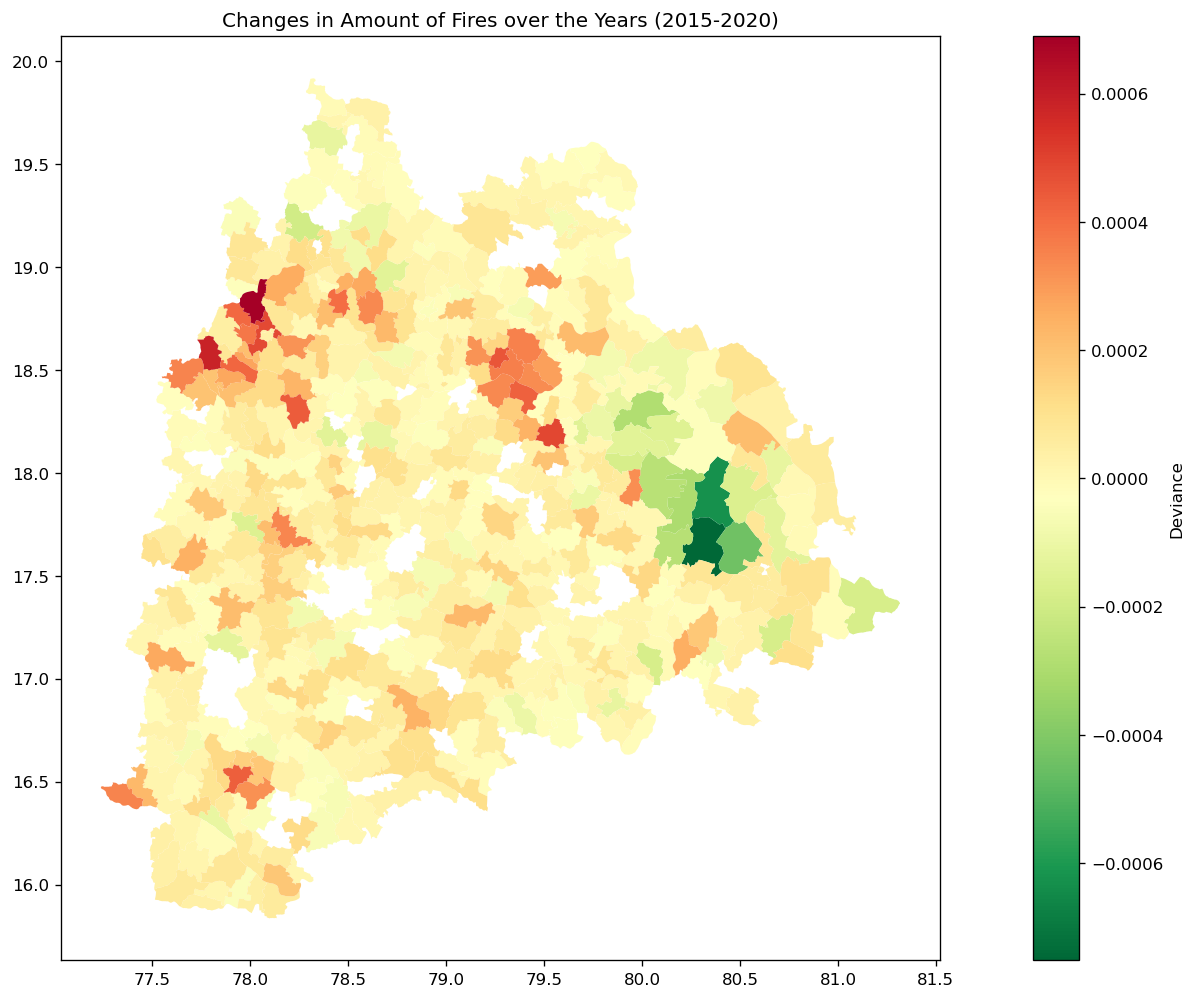

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [304]:
DPPD_df.plot(column = 'Slope Score', 
                      legend = True, 
                      figsize = [20,10],\
                      legend_kwds = {'label': 'Deviance'}, 
                      cmap = 'RdYlGn_r')
plt.title('Changes in Amount of Fires over the Years (2015-2020)')
plt.show()

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


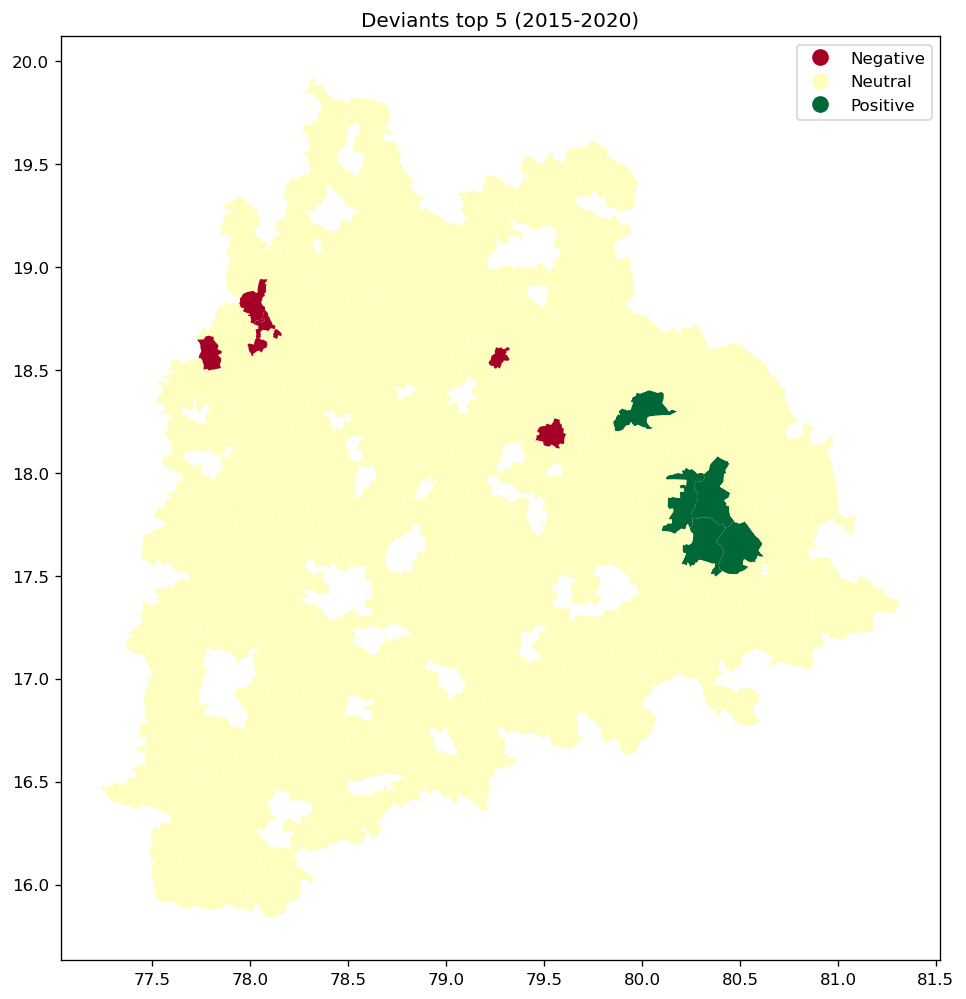

In [296]:
DPPD_df['Deviants'] = 'Neutral'
DPPD_df = DPPD_df.dropna()
DPPD_df['Deviants'].iloc[:5] = 'Positive'
DPPD_df['Deviants'].iloc[-5:] = 'Negative'

DPPD_df.plot(column = 'Deviants', 
                      legend = True, 
                      figsize = [20,10],
                      cmap = 'RdYlGn')
plt.title('Deviants top 5 (2015-2020)')
plt.show()

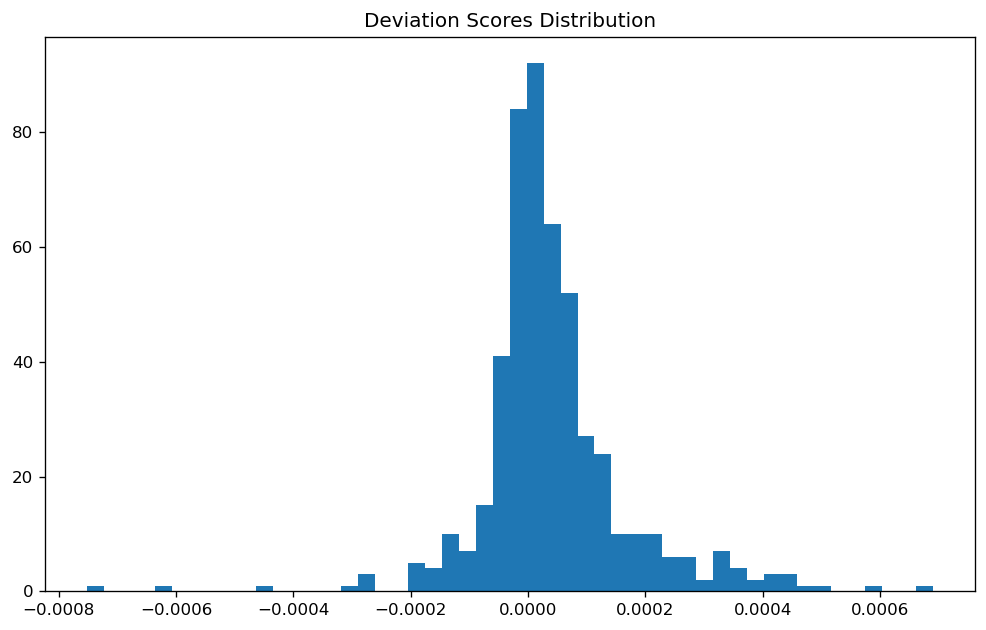

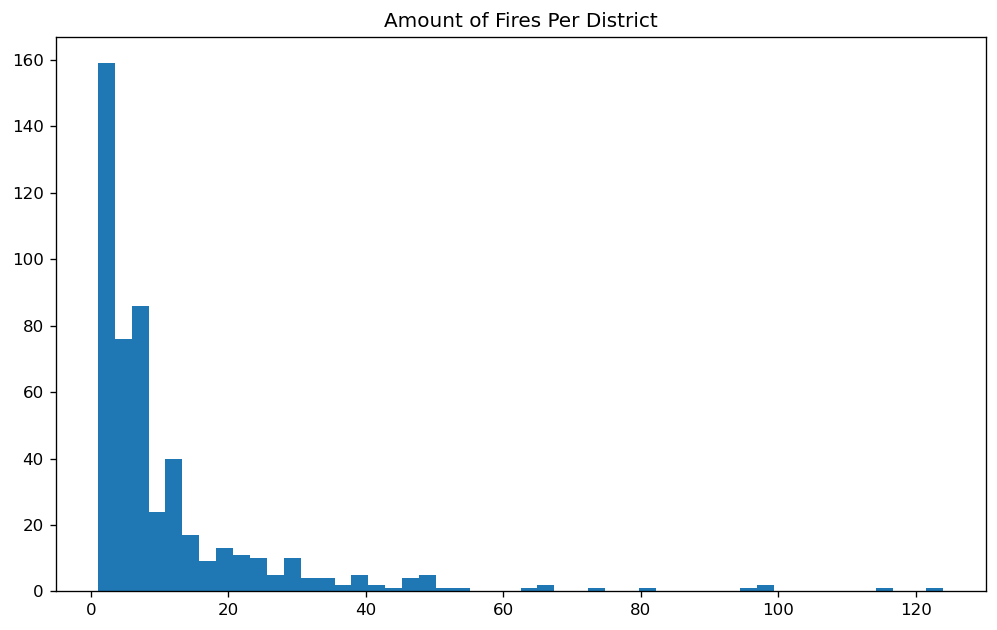

In [302]:
plt.hist(DPPD_df['Slope Score'], bins = 50)
plt.title('Deviation Scores Distribution')
plt.show()

plt.hist(DPPD_df['fireID'], bins = 50)
plt.title('Amount of Fires Per District')
plt.show()

In [298]:
DPPD_df[DPPD_df['Deviants'] == 'Positive']

,Dist_Name,Mandal_Nam,Slope Score,Regression Score,Augmented Dickey Fuller Test,Kpss Test,PhillipsPerron,geometry,fireID,Deviants
0,Bhadradri Kothagudem,Yellandu,-0.000752,0.303074,0.0,0.1,0.0,"POLYGON ((80.34248 17.78495, 80.39431 17.74970...",124,Positive
1,Bhadradri Kothagudem,Gundala,-0.000628,0.848159,0.88118,0.04974,0.0,"POLYGON ((80.42952 18.05816, 80.43134 18.05733...",95,Positive
2,Bhadradri Kothagudem,Tekulapalle,-0.000441,0.717742,0.0,0.1,0.0,"POLYGON ((80.53010 17.75629, 80.53204 17.75473...",50,Positive
3,Mahabubabad,Gangaram,-0.000297,0.140721,0.781013,0.1,0.0,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",97,Positive
4,Mulugu,Venkatapur,-0.000290,0.167323,0.016188,0.1,0.0,"POLYGON ((80.03853 18.40128, 80.04067 18.40109...",73,Positive


In [299]:
DPPD_df[DPPD_df['Deviants'] == 'Negative']

,Dist_Name,Mandal_Nam,Slope Score,Regression Score,Augmented Dickey Fuller Test,Kpss Test,PhillipsPerron,geometry,fireID,Deviants
494,Peddapalli,Eligaid,0.000455,0.536225,0.620497,0.036361,0.0,"POLYGON ((79.31233 18.61133, 79.31250 18.61130...",21,Negative
495,Nizamabad,Nizamabad Rural,0.000486,0.325725,0.001098,0.1,0.0,"MULTIPOLYGON (((78.13497 18.69678, 78.13504 18...",49,Negative
496,Warangal_Urban,Kamalapur,0.000488,0.41405,0.0,0.1,0.0,"POLYGON ((79.56420 18.26239, 79.56486 18.26234...",24,Negative
497,Nizamabad,Kotagiri,0.000585,0.184785,0.0,0.1,0.0,"POLYGON ((77.83827 18.62068, 77.83827 18.61972...",98,Negative
498,Nizamabad,Navipet,0.000690,0.80042,0.595202,0.053165,0.0,"POLYGON ((78.08734 18.94072, 78.08733 18.94070...",67,Negative


In [300]:
DPPD_df['Absolute Slope Score']= abs(DPPD_df['Slope Score'])
DPPD_df_neutrals = DPPD_df[DPPD_df['Absolute Slope Score']<0.00002]
DPPD_df_neutrals.sort_values(['fireID'], ascending = False).head()

,Dist_Name,Mandal_Nam,Slope Score,Regression Score,Augmented Dickey Fuller Test,Kpss Test,PhillipsPerron,geometry,fireID,Deviants,Absolute Slope Score
111,Bhadradri Kothagudem,Dammapeta,-0.000020,0.003262,0.0,0.1,0.0,"POLYGON ((81.01204 17.49259, 81.01205 17.49256...",31,Neutral,0.000020
160,Jayashankar Bhupalpally,Bhupalpally,-0.000005,0.00054,0.0,0.1,0.0,"POLYGON ((79.90614 18.51869, 79.90821 18.51769...",30,Neutral,0.000005
226,Nizamabad,Bheemgal,0.000015,0.004368,0.004829,0.1,0.0,"POLYGON ((78.47735 18.75343, 78.47919 18.75219...",19,Neutral,0.000015
153,Khammam,Mudigonda,-0.000008,0.001303,0.0,0.1,0.0,"POLYGON ((80.16039 17.18372, 80.16069 17.18103...",19,Neutral,0.000008
233,Khammam,Thallada,0.000017,0.004149,0.0,0.1,0.0,"POLYGON ((80.44875 17.30464, 80.44929 17.30445...",19,Neutral,0.000017


<ipython-input-290-874a98902a91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandal['ModifiedDateTime'] =  pd.to_datetime(mandal['ModifiedDateTime'])


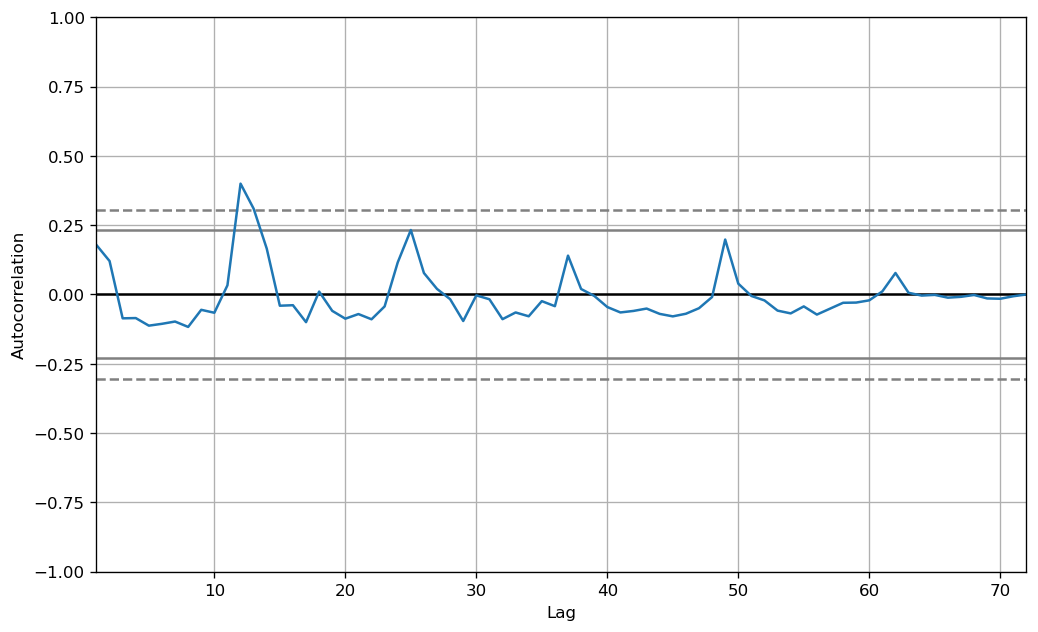

Results of ADF Test:
ADF Statistic: -7.178781
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


Results of KPSS Test:
Test Statistic           0.315853
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


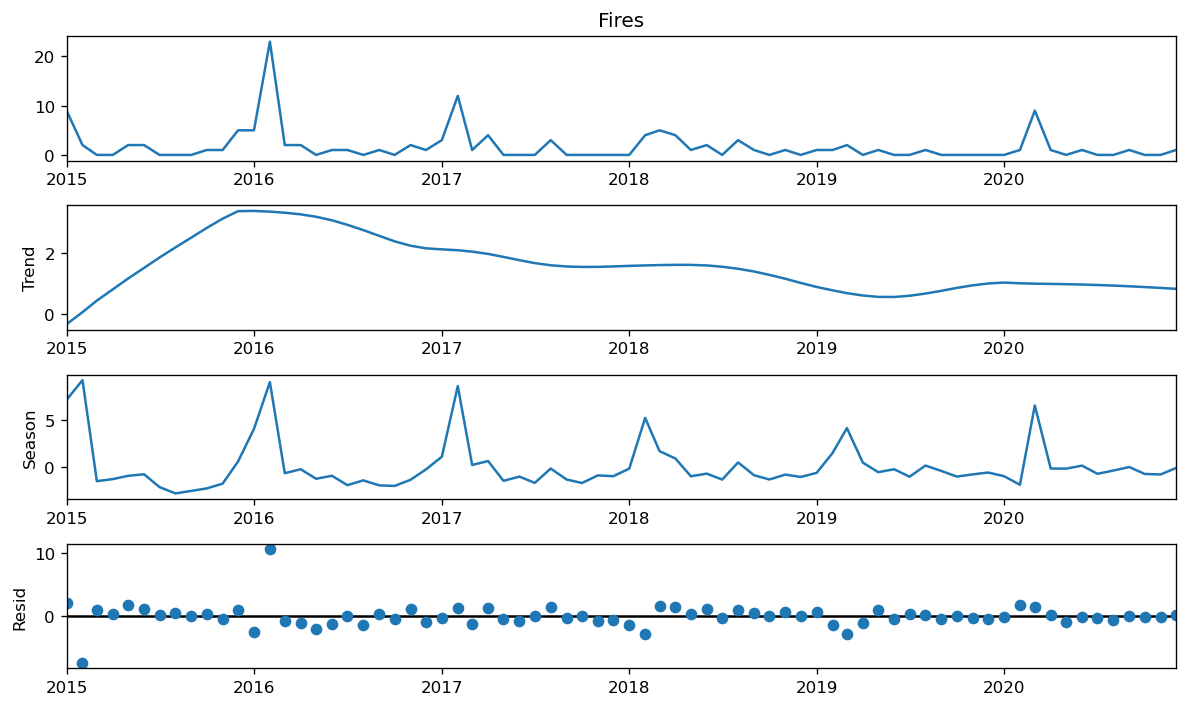

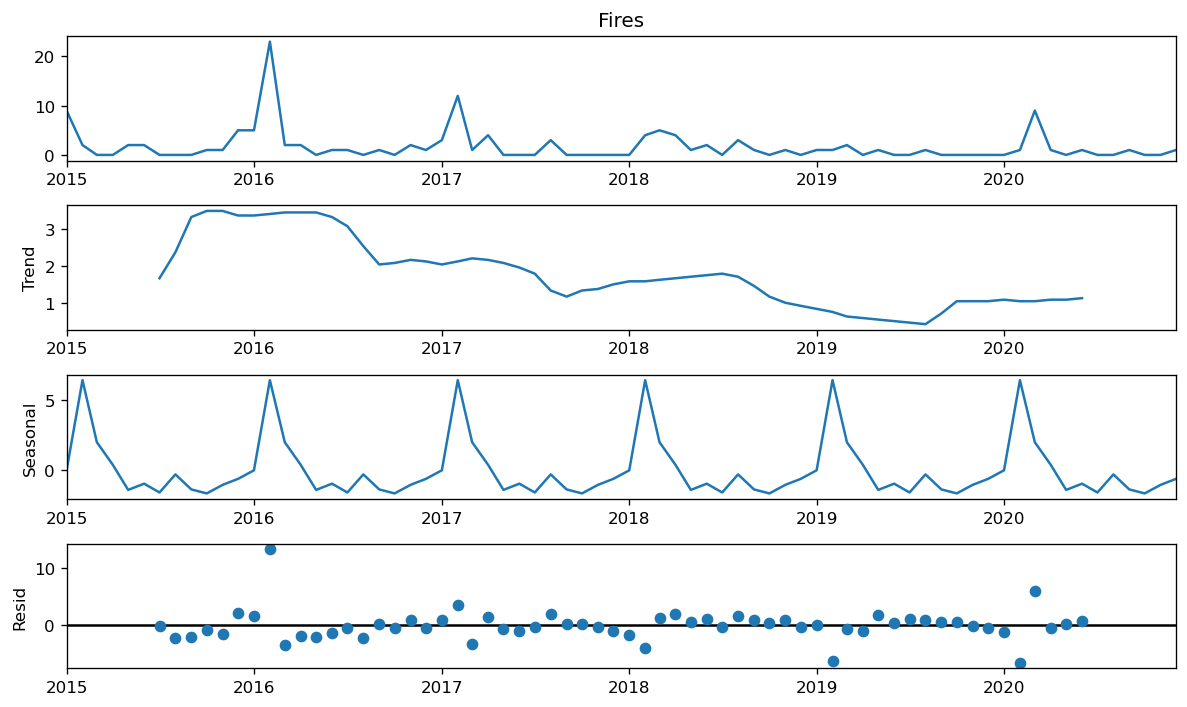

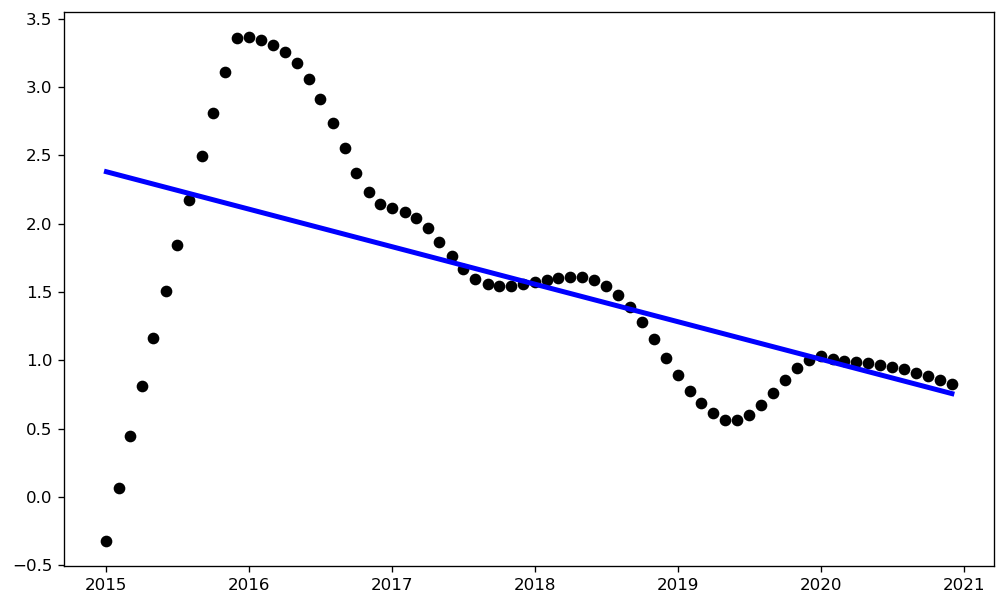

[-0.0007517] [555.33166551]


-0.0007517023495366668

In [303]:
Trend_Mandals_printed(fires_per_mandal_count, 'Bhadradri Kothagudem', 'Yellandu')